# Baseline Model Extension
In my baseline model notebook, I originally used K-means to cluster my crime reports into 5 separate clusters. After clustering, I used PCA to reduce the dimension of my data and visualize the resulting clusters on a 2D and 3D plane. Since I want to compare the results of my baseline K-means model with other potential models, I will first use another dimension reduction technique known as t-distributed stochastic neighbor embedding (t-SNE) to visualize what my crime reports may look like. 

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from collections import Counter
from sklearn.decomposition import PCA

import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

# Import necessary modules for Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

# # Import necessary modules for k-modes clustering
from kmodes.kmodes import KModes

# Code below referenced from https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
# That's an impressive list of imports.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

## Reproducing cluster assignments via K-means clustering

In [2]:
# Grab dataframe containing police reports
# Create df on Macbook
# df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_1_data/merged.csv")

# Create df on PC
df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_1_data/merged.csv")
df = df.drop(columns='Unnamed: 0')

In [3]:
def label_hour(row):
    """Return either monring, afternoon, evening, or night depending on the hour of the day"""
    hour = int(row["Incident Hour"])
    if hour >= 5 and hour < 12: #5:00am to 11:59am
        return 'morning'
    elif hour >= 12 and hour < 17: #12:00pm to 4:59pm
        return 'afternoon'
    elif hour >= 17 and hour < 21: # 5:00pm to 8:59pm
        return 'evening'
    return 'night' # 9:00pm to 4:49am


def label_season(row):
    """Return either spring, summer, fall, or winter depending on the month of the year"""
    month = row["Incident Month"]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    winter = [12, 1, 2]
    
    if month in spring:
        return 'spring'
    elif month in summer:
        return 'summer'
    elif month in fall:
        return 'fall'
    return 'winter'

# Add "Hour" and "Month" columns
df["Incident Month"] = pd.to_datetime(df["Incident Date"]).dt.month
df["Incident Hour"] = df["Incident Time"].str.split(':').str[0]

# Add "season" and "time categories" columns
df['Time Category'] = df.apply(lambda row: label_hour(row), axis=1)
df['Season'] = df.apply(lambda row: label_season(row), axis=1)

In [4]:
# Crime Data Warehouse Data Frame
cdw_df = df[df["Incident Year"] > 2017].copy()
cdw_df["Incident Hour"] = cdw_df["Incident Hour"].astype(int)

In [5]:
# Create dummy variables for categorical crime features to be used for k-means model
dummies_df = pd.get_dummies(data=cdw_df, columns=["Incident Category", "Incident Day of Week", "Police District"])
columns = ["Incident Hour", "Incident Month", 'Incident Category_Arson', 'Incident Category_Assault',
       'Incident Category_Burglary', 'Incident Category_Case Closure',
       'Incident Category_Civil Sidewalks',
       'Incident Category_Courtesy Report',
       'Incident Category_Disorderly Conduct',
       'Incident Category_Drug Offense', 'Incident Category_Drug Violation',
       'Incident Category_Embezzlement', 'Incident Category_Family Offense',
       'Incident Category_Fire Report',
       'Incident Category_Forgery And Counterfeiting',
       'Incident Category_Fraud', 'Incident Category_Gambling',
       'Incident Category_Homicide',
       'Incident Category_Human Trafficking (A), Commercial Sex Acts',
       'Incident Category_Human Trafficking, Commercial Sex Acts',
       'Incident Category_Juvenile Offenses',
       'Incident Category_Larceny Theft', 'Incident Category_Liquor Laws',
       'Incident Category_Lost Property',
       'Incident Category_Malicious Mischief',
       'Incident Category_Miscellaneous Investigation',
       'Incident Category_Missing Person',
       'Incident Category_Motor Vehicle Theft',
       'Incident Category_Motor Vehicle Theft?',
       'Incident Category_Non-Criminal',
       'Incident Category_Offences Against The Family And Children',
       'Incident Category_Other', 'Incident Category_Other Miscellaneous',
       'Incident Category_Other Offenses', 'Incident Category_Prostitution',
       'Incident Category_Rape', 'Incident Category_Recovered Vehicle',
       'Incident Category_Robbery', 'Incident Category_Sex Offense',
       'Incident Category_Stolen Property', 'Incident Category_Suicide',
       'Incident Category_Suspicious', 'Incident Category_Suspicious Occ',
       'Incident Category_Traffic Collision',
       'Incident Category_Traffic Violation Arrest',
       'Incident Category_Vandalism', 'Incident Category_Vehicle Impounded',
       'Incident Category_Vehicle Misplaced', 'Incident Category_Warrant',
       'Incident Category_Weapons Carrying Etc',
       'Incident Category_Weapons Offence',
       'Incident Category_Weapons Offense', 'Incident Day of Week_Friday',
       'Incident Day of Week_Monday', 'Incident Day of Week_Saturday',
       'Incident Day of Week_Sunday', 'Incident Day of Week_Thursday',
       'Incident Day of Week_Tuesday', 'Incident Day of Week_Wednesday',
       'Police District_Bayview', 'Police District_Central',
       'Police District_Ingleside', 'Police District_Mission',
       'Police District_Northern', 'Police District_Out of SF',
       'Police District_Park', 'Police District_Richmond',
       'Police District_Southern', 'Police District_Taraval',
       'Police District_Tenderloin']
dummy_cols = dummies_df[columns]

# Convert dummy data frame to numpy array
dummy_np_arr = dummy_cols.to_numpy()

In [6]:
# Build KMeans model initialized with 5 clusters
model = KMeans(n_clusters = 5)
model.fit_predict(dummy_np_arr)

array([1, 1, 1, ..., 1, 4, 4])

In [7]:
# Get cluster assignments for each and add to Crime Data Warehouse Data Frame
cluster_assignments = model.labels_
cdw_df.loc[:,"cluster_id"] = cluster_assignments

In [8]:
# Code referenced from https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 5))

    # We create a scatter plot.
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    plt.title("Scatter Plot using t-SNE with 5 Labelled Clusters")
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(5):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

## Randomly select sample from Crime Data Warehouse

In [9]:
# Generate a smaller sample of the Crime Data Warehouse Data Frame
sample = cdw_df.sample(1000, random_state=41)

In [10]:
# Create dummy variables for categorical crime features to be used for k-means model
dummy_sample_df = pd.get_dummies(data=sample, columns=["Incident Category", "Incident Day of Week", "Police District"])
dummy_sample_cols = ["Incident Hour", "Incident Month", 'Incident Category_Arson', 'Incident Category_Assault',
       'Incident Category_Burglary', 'Incident Category_Case Closure',
       'Incident Category_Civil Sidewalks',
       'Incident Category_Courtesy Report',
       'Incident Category_Disorderly Conduct',
       'Incident Category_Drug Offense', 'Incident Category_Family Offense',
       'Incident Category_Forgery And Counterfeiting',
       'Incident Category_Fraud',
       'Incident Category_Human Trafficking (A), Commercial Sex Acts',
       'Incident Category_Juvenile Offenses',
       'Incident Category_Larceny Theft', 'Incident Category_Lost Property',
       'Incident Category_Malicious Mischief',
       'Incident Category_Miscellaneous Investigation',
       'Incident Category_Missing Person',
       'Incident Category_Motor Vehicle Theft',
       'Incident Category_Non-Criminal',
       'Incident Category_Offences Against The Family And Children',
       'Incident Category_Other', 'Incident Category_Other Miscellaneous',
       'Incident Category_Other Offenses', 'Incident Category_Prostitution',
       'Incident Category_Recovered Vehicle', 'Incident Category_Robbery',
       'Incident Category_Sex Offense', 'Incident Category_Stolen Property',
       'Incident Category_Suspicious Occ',
       'Incident Category_Traffic Violation Arrest',
       'Incident Category_Vandalism', 'Incident Category_Vehicle Misplaced',
       'Incident Category_Warrant', 'Incident Category_Weapons Carrying Etc',
       'Incident Category_Weapons Offense', 'Incident Day of Week_Friday',
       'Incident Day of Week_Monday', 'Incident Day of Week_Saturday',
       'Incident Day of Week_Sunday', 'Incident Day of Week_Thursday',
       'Incident Day of Week_Tuesday', 'Incident Day of Week_Wednesday',
       'Police District_Bayview', 'Police District_Central',
       'Police District_Ingleside', 'Police District_Mission',
       'Police District_Northern', 'Police District_Out of SF',
       'Police District_Park', 'Police District_Richmond',
       'Police District_Southern', 'Police District_Taraval',
       'Police District_Tenderloin']

dummy_sample_df = dummy_sample_df.sort_values(["cluster_id"])
dummy_sample_np_arr = dummy_sample_df[dummy_sample_cols].to_numpy()

## Application of t-SNE
All code below is referenced from https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm and fitted with my data to help me utilize sklearn's TSNE toolkit. The following is another example of me reducing the dimensionality of my data to a 2D plot.

In [11]:
# Set up tsne inputs
X = dummy_sample_np_arr
y = dummy_sample_df.cluster_id.values

In [12]:
# Fit data to tnse plot
cluster_proj = TSNE(random_state=RS).fit_transform(X)

(<Figure size 720x720 with 1 Axes>,
 [Text(23.297672, -12.062511, '0'),
  Text(-12.574933, 49.0384, '1'),
  Text(-0.5748539, -27.409546, '2'),
  Text(-18.775951, 10.443649, '3'),
  Text(8.44187, 13.320581, '4')])

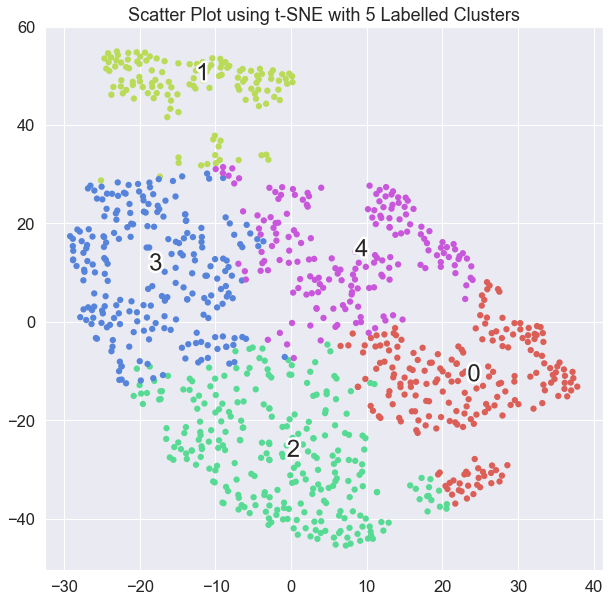

In [13]:
# Display tsne output
scatter(cluster_proj, y)

### Response:
The above plot was constructed from a sample taken from the Crime Data Warehouse. I previously ran my baseline k-means algorithm on the data set to construct the potential cluster labels, and from there I created a scatter plot for the crime reports on the output of t-SNE. The output of t-SNE is the resulting plot, and I colored each data point on what cluster each point would belong to if I used my k-means model.

This scatter plot tells me that there are crime reports that could be similar in nature and can potentially be grouped together. The clusters from t-SNE don't tell me which crime reports *should* be grouped together, but the visualization does highlight that some reports are more similar to each other than others. It is easier to see some relationships between crime reports compared to my 3D PCA visualization since my data set has a high number of features and t-SNE is a non-linear dimension reduction algorithm.

# Application of a new clustering algorithm: k-modes


K-modes is similar to k-means due to the fact that they require the number of clusters to be known before running, and that k-modes is essentially an extension of k-means. However, one key difference is the way that distances between points is calculated. Rather than computing euclidean distances in k-means (which requires numerical data for the distances to be calculated), k-modes uses the dissimilarity between objects and finds the *mode* (cluster centroid) vector that minimizes the dissimilarity between itself and its corresponding data. This makes k-modes good for categorical data since it doesn't require numerical inputs. By using Panda's *get_dummies()* method, I can form dummy variables for each selected categorical feature to be used in my k-modes algorithm.

In [14]:
# Sample from Crime Data Warehouse
sample = cdw_df.sample(10000, random_state=1)

In [15]:
# Create dummy variables for categorical crime features to be used for k-modes model
dummy_kmodes_df = pd.get_dummies(data=sample, columns=["Incident Category", "Incident Day of Week", "Police District", "Incident Month", "Incident Hour"])
cols = dummy_kmodes_df.columns[15:]

kmodes_np_arr = dummy_kmodes_df[cols].to_numpy()

## Selecting the *k* value via k-modes' cost function

In [16]:
def get_kmodes_costs(data, k_min, k_max):
    """Gets cost of k-modes model for each k value for each value in range(k_min, k_max + 1)"""
    costs = []
    
    for k in range(k_min, k_max+1):
        kmodes_model = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)
        kmodes_model.fit(data)
        costs.append(kmodes_model.cost_)
    
    return costs

In [17]:
# Get sum-of-squares errors for k values 2 <= k <= 10
costs = get_kmodes_costs(kmodes_np_arr, 2, 10)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1255, cost: 48607.0
Run 1, iteration: 2/100, moves: 0, cost: 48607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2606, cost: 48557.0
Run 2, iteration: 2/100, moves: 1366, cost: 48557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2755, cost: 48607.0
Run 3, iteration: 2/100, moves: 1380, cost: 48607.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2156, cost: 48557.0
Run 4, iteration: 2/100, moves: 1406, cost: 48557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2336, cost: 48607.0
Run 5, iteration: 2/100, moves: 468, cost: 49063.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Start

Run 3, iteration: 3/100, moves: 1161, cost: 39125.0
Run 3, iteration: 4/100, moves: 54, cost: 39125.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 5066, cost: 41988.0
Run 4, iteration: 2/100, moves: 952, cost: 41465.0
Run 4, iteration: 3/100, moves: 48, cost: 41465.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 5245, cost: 39483.0
Run 5, iteration: 2/100, moves: 208, cost: 39483.0
Best run was number 3


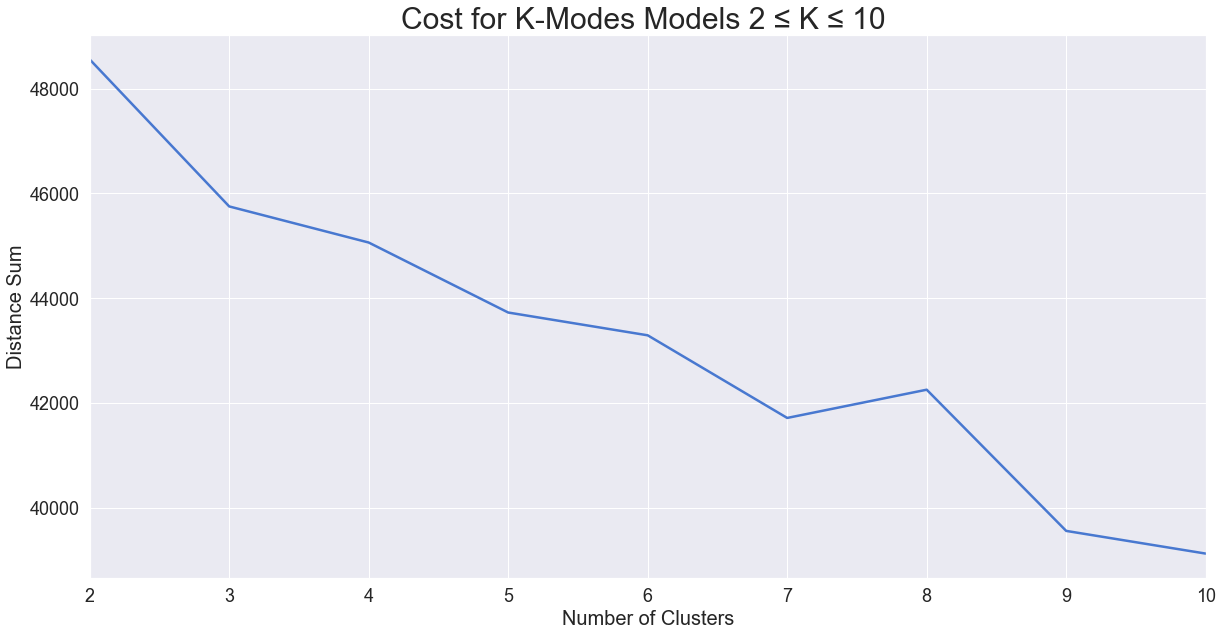

In [18]:
# Plot costs value against each k value
plt.figure(figsize=(20,10))
    
plt.plot(range(2, 11), costs)
plt.xlim([2,10])
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylabel('Distance Sum', fontsize=20)
plt.xticks(range(2,11), size = 18)
plt.yticks(size = 18)
plt.title('Cost for K-Modes Models 2 ≤ K ≤ 10 ', size=30)
plt.show()

The "distance sum" (cluster cost) for each cluster value is defined as the sum distance of all points to their respective cluster centroids, meaning that lower values represent tighter clusters. Using the Elbow Method to select my k-value, it appears that when k=5, the cost function flattens out. I will build my k-modes model with 5 clusters and compare my results to my baseline k-means model (which also had 5 clusters).

## Building k-modes model with 5 clusters

In [33]:
km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(kmodes_np_arr)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4180, cost: 44378.0
Run 1, iteration: 2/100, moves: 138, cost: 44378.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6612, cost: 44824.0
Run 2, iteration: 2/100, moves: 2354, cost: 44824.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5354, cost: 44671.0
Run 3, iteration: 2/100, moves: 1231, cost: 44671.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4781, cost: 45206.0
Run 4, iteration: 2/100, moves: 987, cost: 45206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4479, cost: 43726.0
Run 5, iteration: 2/100, moves: 0, cost: 43726.0
Best run was number 5


In [34]:
sample["cluster_id"] = km.labels_

In [35]:
# Assign variables to hold each cluster
c0 = sample[sample.cluster_id == 0]
c1 = sample[sample.cluster_id == 1]
c2 = sample[sample.cluster_id == 2]
c3 = sample[sample.cluster_id == 3]
c4 = sample[sample.cluster_id == 4]

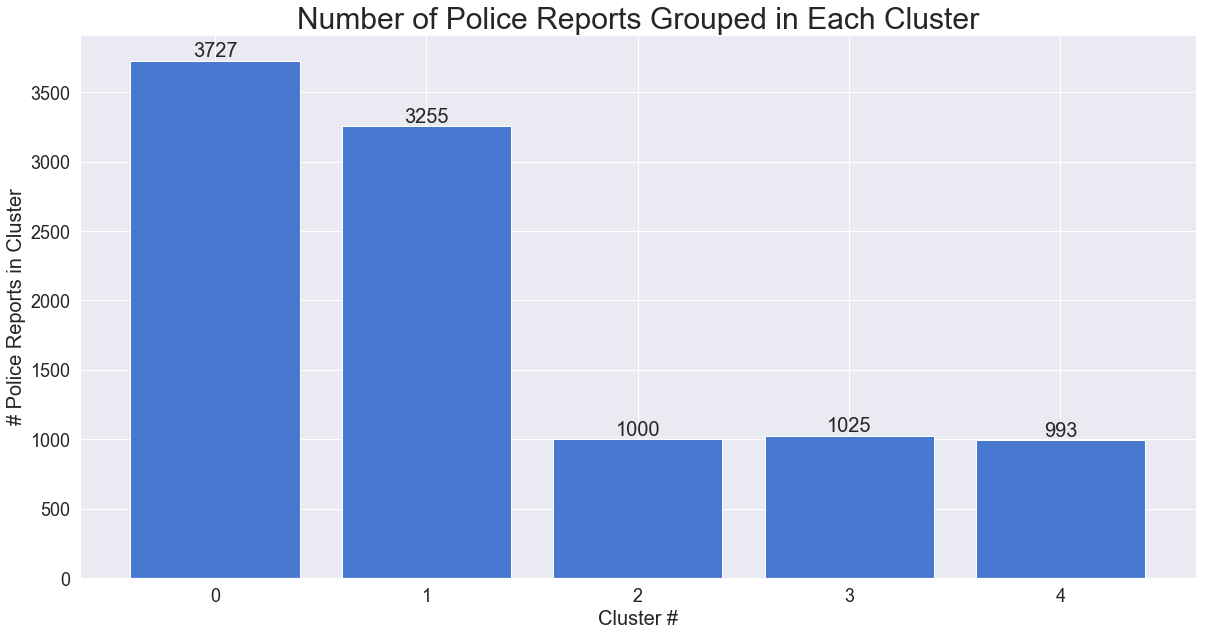

In [36]:
# Plot the bar chort of number of reports by cluster
plt.figure(figsize=(20,10))
plot = plt.bar(list(sample.groupby('cluster_id').size().index), list(sample.groupby('cluster_id').size().values),  align='center')
plt.xlabel('Cluster #', fontsize=20)
plt.ylabel('# Police Reports in Cluster', fontsize=20)
plt.xticks(range(0, 5), size = 18)
plt.yticks(size = 18)
plt.title('Number of Police Reports Grouped in Each Cluster', fontsize=30)

# Add crime total above each bar
for bar in plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=20)
    
plt.show()

# Looking deeper into each cluster

The above graph is just to give me a sense of how many police reports are in each cluster. What is more important is what each cluster represents in terms of the composition of the police reports. Due to the randomness of my sample, there could be some bias in terms of the reports that were selected. This is why I am going to look deeper into what each cluster contains and if there are underlying patterns that these clusters tell me and how they relate to my k-means model.

## What type of crimes are in each cluster?

In [37]:
def top_8_pie(cluster):
    """Plots pie chart of top 5 categories per cluster"""
    
    top_8 = Counter(cluster["Incident Category"].tolist()).most_common(8)
    
    categories = [x[0] for x in top_8]
    values = [x[1] for x in top_8]
    other_val = len(cluster) - sum(values)
    
    # Get 'other' category for crimes not in top 8
    categories.append("Other")
    values.append(other_val)
    
    # Plot pie chart
    plt.pie(values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Classification % Distribution", fontsize=20)

    plt.axis('equal')

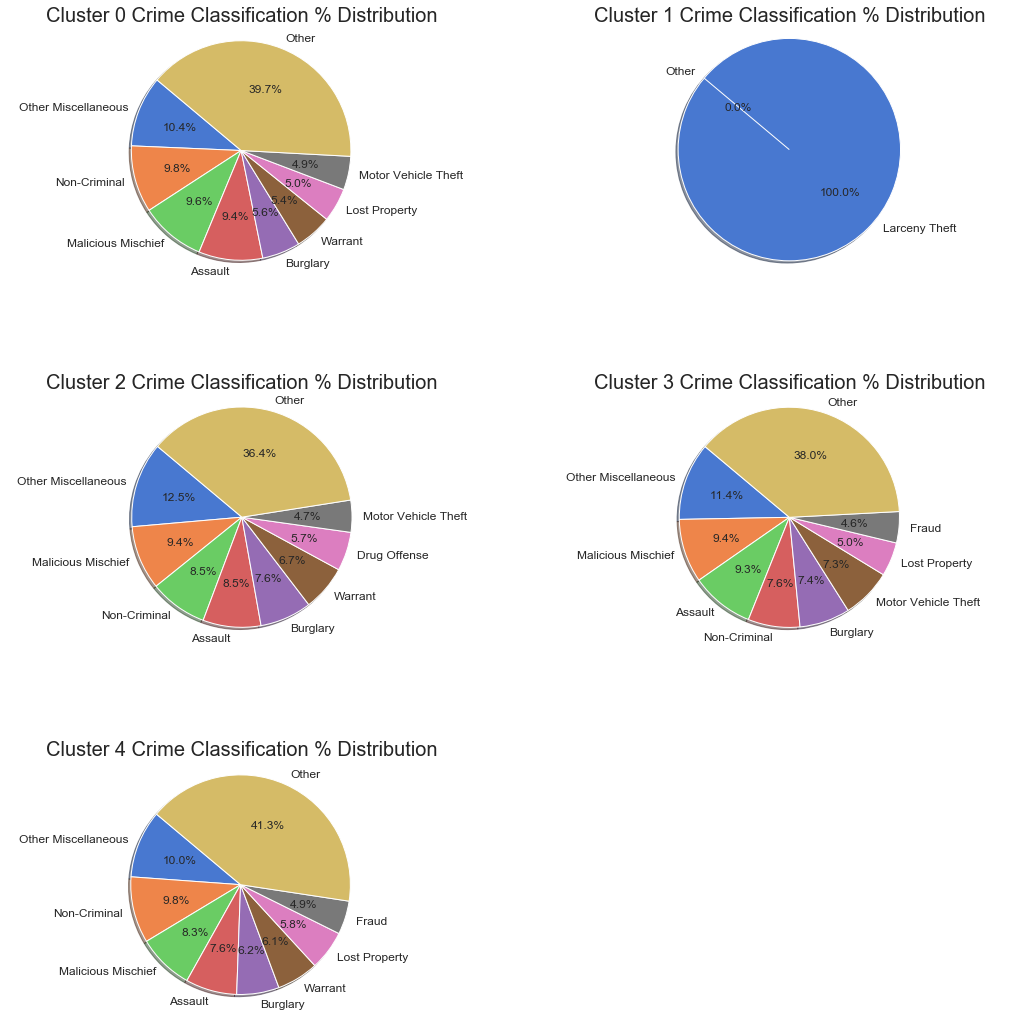

In [38]:
# Plot pie charts for each cluster's percentage distribution of crime classifications
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
top_8_pie(c0)
plt.subplot2grid((3,2),(0,1))
top_8_pie(c1)
plt.subplot2grid((3,2),(1,0))
top_8_pie(c2)
plt.subplot2grid((3,2),(1,1))
top_8_pie(c3)
plt.subplot2grid((3,2),(2,0))
top_8_pie(c4)

## What days are crime reports most frequent in each cluster?

In [39]:
def plot_days(cluster):
    """Plots bar graph of crime reports per day for a given cluster"""
    
    # List of bar characteristics
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    totals = []
    colors = ['orange', 'y', 'green', 'blue', 'purple', 'black', 'red']

    for day in days:
        total = sum(cluster["Incident Day of Week"] == day)
        totals.append(total)
    
    # Plot bar graph and add grid
    plot = plt.bar(days, totals, color=colors, zorder=2)
    plt.grid(True)
    
    # Add title, axes labels, and adjust x and y ticks
    plt.title("Crime Reports by Day Cluster " + str(cluster.cluster_id.iloc[0]), fontsize=24)
    plt.xlabel("Day", fontsize=16)
    plt.ylabel("Number of Crime Reports", fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.yticks(fontsize=13)
    plt.ylim(0,1100)

    # Add crime total above each bar
    for bar in plot:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=11)

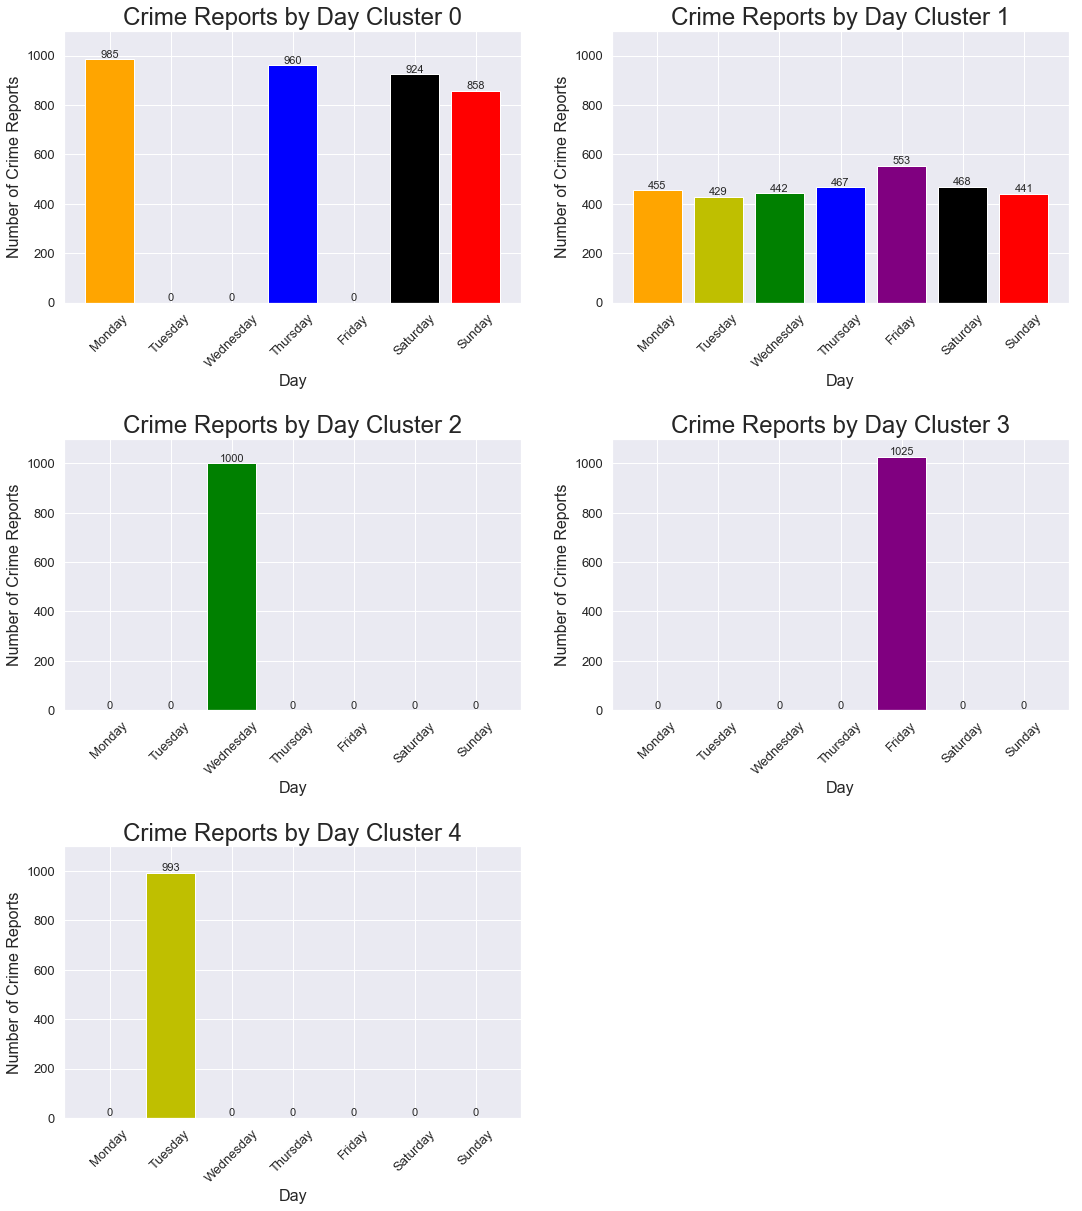

In [40]:
# Create figure to display crimes reported per day of the week for each cluster
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_days(c0)
plt.subplot2grid((3,2),(0,1))
plot_days(c1)
plt.subplot2grid((3,2),(1,0))
plot_days(c2)
plt.subplot2grid((3,2),(1,1))
plot_days(c3)
plt.subplot2grid((3,2),(2,0))
plot_days(c4)

## What times of the day are most common for crimes in each cluster?

In [41]:
def plot_times_per_day(cluster):
    """Plot the total number of reports for times of crimes"""
    time_categories = ["morning", "afternoon", "evening", "night"]
    xlabels = ["Morning\n(5:00am-11:59am)", "Afternoon\n(12:00pm-4:59pm)", "Evening\n(5:00pm-8:59pm)", "Night\n(9:00pm-4:49am)"]
    totals = []

    for tc in time_categories:
        totals.append(sum(cluster["Time Category"] == tc))

    plt.bar(xlabels, totals, color=('goldenrod', 'royalblue', 'maroon', 'k'))
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Report Times of Day", fontsize=23)
    plt.xlabel("Time Reported", fontsize=17)
    plt.ylabel("# Reports", fontsize=17)
    plt.ylim(0, 1500)
    plt.xticks(fontsize=14)

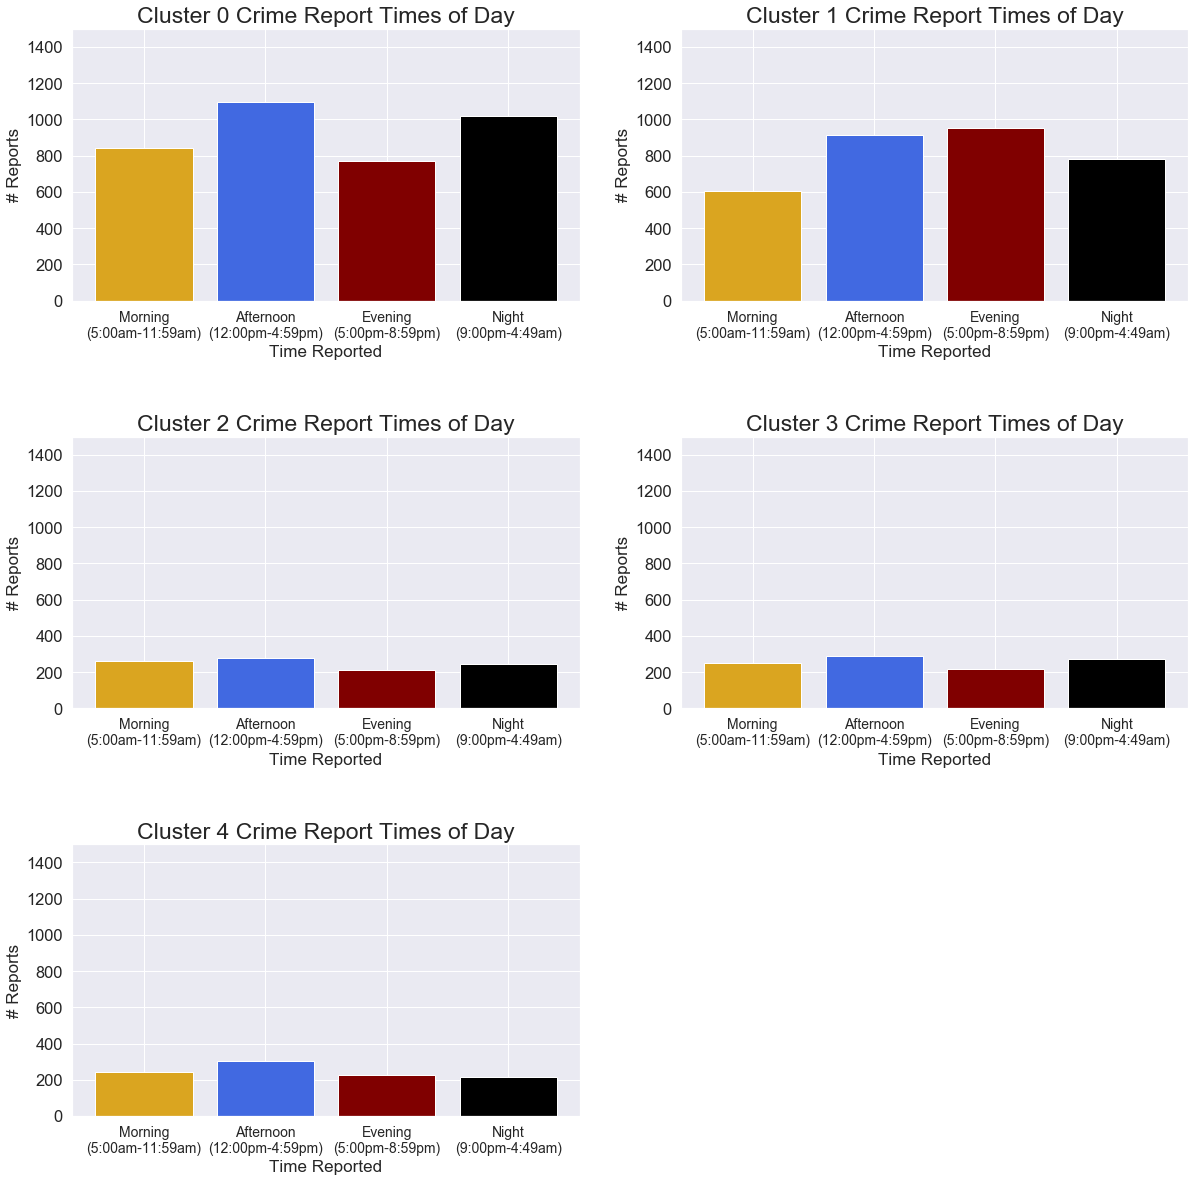

In [42]:
# Create figure to display crimes reported per day of the week for each cluster
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_times_per_day(c0)
plt.subplot2grid((3,2),(0,1))
plot_times_per_day(c1)
plt.subplot2grid((3,2),(1,0))
plot_times_per_day(c2)
plt.subplot2grid((3,2),(1,1))
plot_times_per_day(c3)
plt.subplot2grid((3,2),(2,0))
plot_times_per_day(c4)

## What times of the year are most common for crimes in each cluster?

In [43]:
def plot_times_per_year(cluster):
    """Plot the total number of reports for each season per cluster"""
    seasons = ["spring", "summer", "fall", "winter"]
    xlabels = ["Spring\n(Mar-May)", "Summer\n(Jun-Aug)", "Fall\n(Sep-Nov)", "Winter\n(Dec-Feb)"]
    totals = []

    for s in seasons:
        totals.append(sum(cluster.Season == s))

    plt.bar(xlabels, totals, color=('springgreen', 'firebrick', 'darkorange', 'lightskyblue'))
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Reports per Season", fontsize=20)
    plt.xlabel("Season", fontsize=17)
    plt.ylabel("# Reports", fontsize=17)
    plt.ylim(0, 1700)
    plt.xticks(fontsize=12)

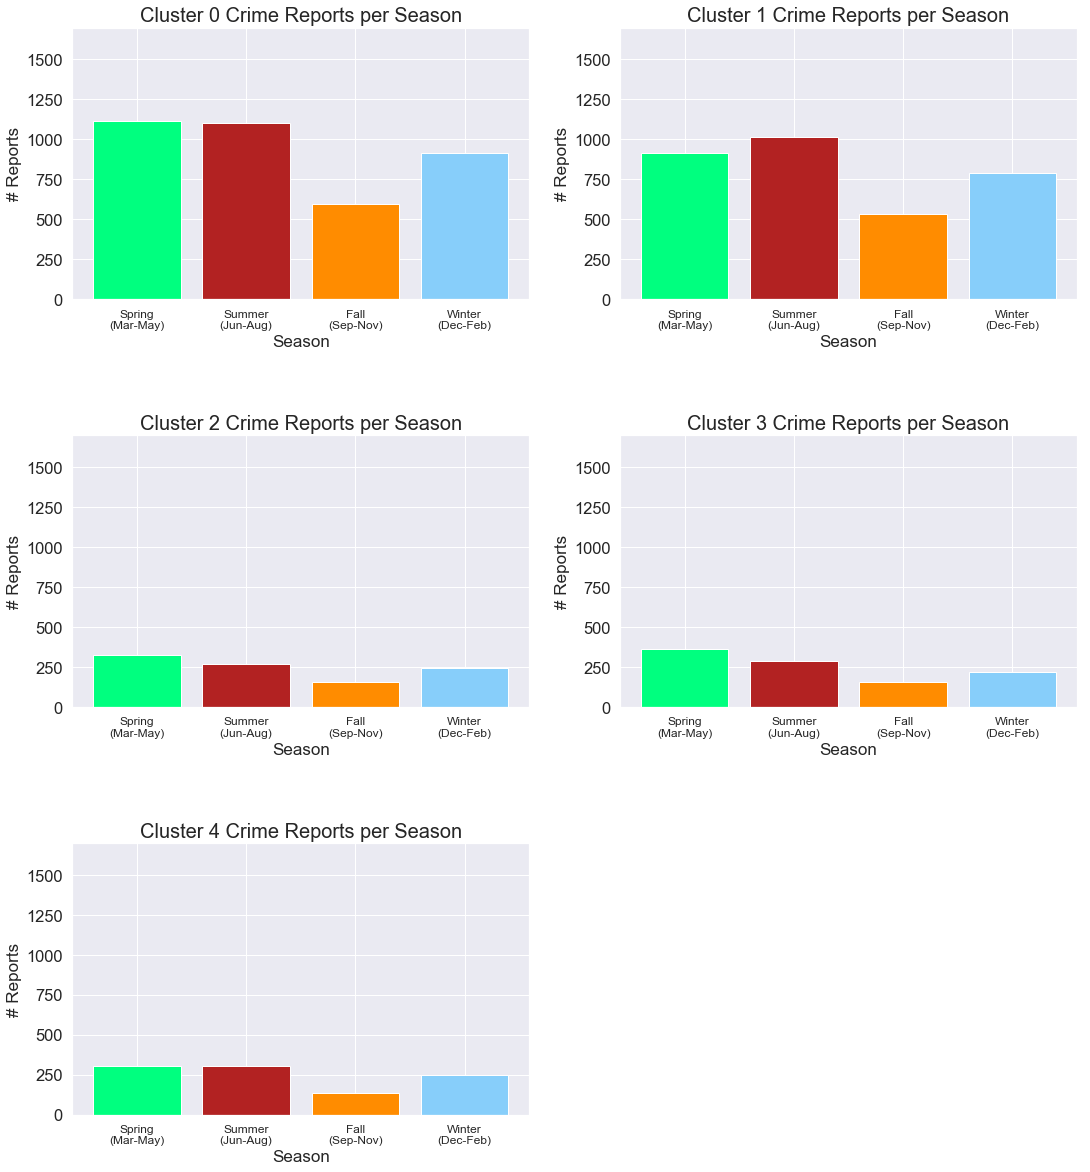

In [44]:
# Create figure to display crimes reported per season for each cluster
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_times_per_year(c0)
plt.subplot2grid((3,2),(0,1))
plot_times_per_year(c1)
plt.subplot2grid((3,2),(1,0))
plot_times_per_year(c2)
plt.subplot2grid((3,2),(1,1))
plot_times_per_year(c3)
plt.subplot2grid((3,2),(2,0))
plot_times_per_year(c4)

## Which police district crime reports are most frequent in each cluster?

In [45]:
def pd_top_5_pie(cluster):
    """Plots pie chart of top 5 police districts per cluster"""
    
    top_5 = Counter(cluster["Police District"].tolist()).most_common(5)
    
    categories = [x[0] for x in top_5]
    values = [x[1] for x in top_5]
    other_val = len(cluster) - sum(values)
    
    # Get 'other' category for crimes not in top 8
    categories.append("Other")
    values.append(other_val)
    
    # Plot pie chart
    plt.pie(values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Police District % Distribution", fontsize=20)

    plt.axis('equal')

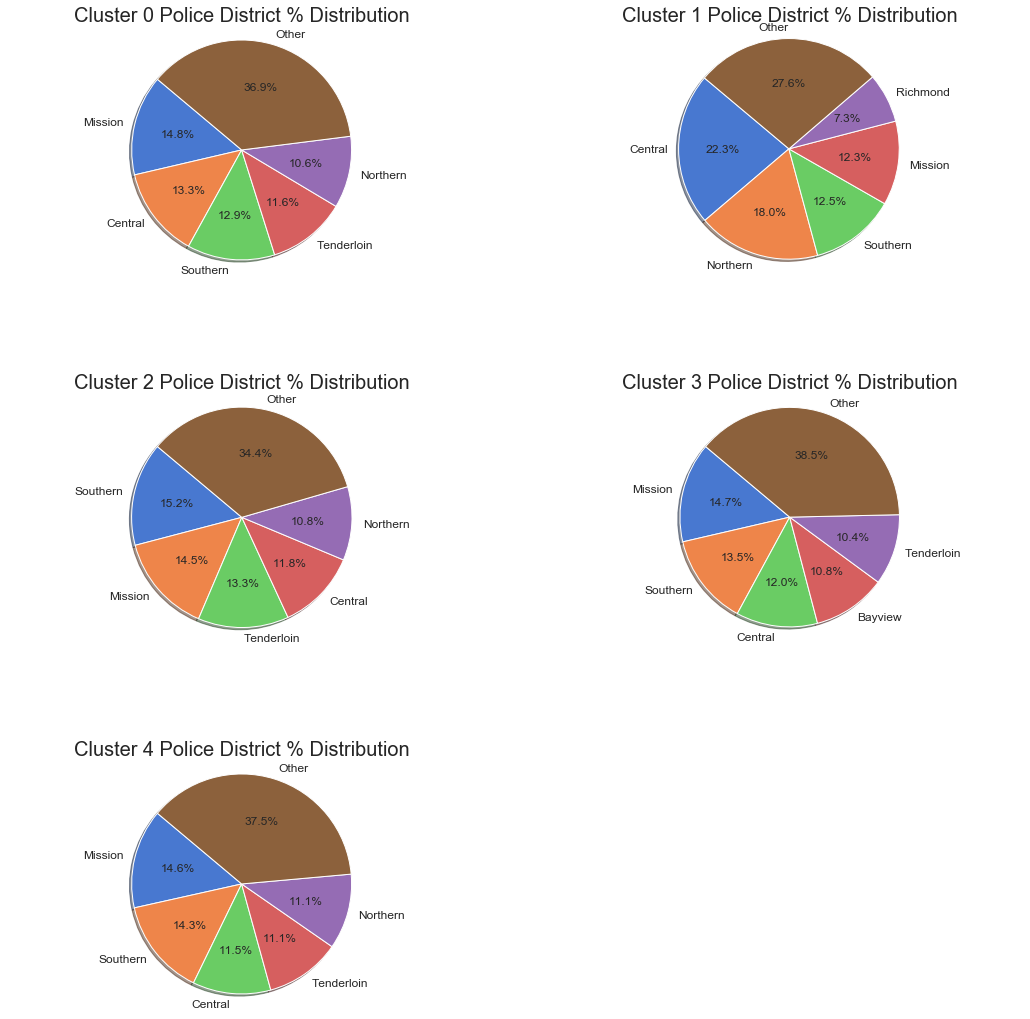

In [46]:
# Plot pie charts for each cluster's percentage distribution of police districts
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
pd_top_5_pie(c0)
plt.subplot2grid((3,2),(0,1))
pd_top_5_pie(c1)
plt.subplot2grid((3,2),(1,0))
pd_top_5_pie(c2)
plt.subplot2grid((3,2),(1,1))
pd_top_5_pie(c3)
plt.subplot2grid((3,2),(2,0))
pd_top_5_pie(c4)

# Conclusion
For reference: *c0* = cluster 0, *c1* = cluster 1, etc.

With k-modes being applied to the data set, there are a couple of points that I would like to highlight. 

Some individual feature graph had some interesting clusters stand out. When plotting the crime clusters by crime classification, *c1* contained only Larceny Theft reports. *c2*, *c3*, and *c4* contained only reports from Wednesday, Friday, and Tuesday respectively.

These individual unique characteristics are quite different compared to my k-means algorithm. A big takeaway that I got from running different clustering algorithms on the Crime Data Warehouse is that no single algorithm can reveal all the underlying patterns of my crime data. Some may be better for certain things, but because k-modes specifically targets categorical data, I feel like this model would be better to represent my data set. If I were to continue working with this algorithm, I would dig deeper into clustering on different features other than the ones I chose and on different cluster numbers to see how each model differs. I believe further exploring on a different sample would also be beneficial to account for the randomness in my current clustered sample.